# Code for training the neural network to predict a geomagnetic baseline
### This code is a part of the manuscript "A novel neural network-based approach to derive a geomagnetic baseline for robust characterization of geomagnetic indices at mid-latitude" by Kieokaew et al., submitted to Space Weather. 

Author: Rungployphan Kieokaew (rkieokaew@irap.omp.eu) 

Last update: 20/12/2024

### This code is to train the neural network with the data in 1991 - 2001, validation in 2002, and testing in 2003.

### The trained model is then saved as the initial model that can be updated later with newer data. 

### To run this code, follow the steps in "instruction.txt" to set up the environment first. 

## Import necessary Python modules

In [3]:
#! pip install pandas

In [4]:
from numpy import mean
from numpy import std
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from dateutil.relativedelta import relativedelta

In [5]:
# Make sure the right Python kernel is chosen (e.g., keras-env) 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras import optimizers
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from datetime import datetime

2024-12-20 09:30:45.292464: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fix random seeds for producible results

In [6]:
# Seed value
seed = 1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

# 5. Configure a new global `tensorflow` session
from keras import backend as K

# Configure Tensorflow-keras session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session


<function keras.backend.set_session(session)>

## Settings

In [7]:
## Neural network settings
dropout_ratio = 0.3
batch_size = 256
num_steps = 12 #Length of the sequential inputs

## Input and output features
input_features = ['LT','SZA','DistSE','F10.7']
output_targets = ['xD','yD','zD']

## Specify paths for saving 'trained' models and results

In [8]:
folder_path = "DailyQuietVariation_LSTM_Initial" #change here 
model_path = "Saved_models/" + str(folder_path)
fig_path = "Plots/" + str(folder_path)
data_path = "Saved_data/" + str(folder_path)

scaler_file = "Scaler_" + str(folder_path) + ".pkl"

## Create paths if not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

if not os.path.exists(data_path):
    os.makedirs(data_path)

## Model path
filepath= str(model_path) + "/Step0_weights.best.hdf5"
## Figure name for the validation data
figname = str(fig_path) + "/Validation_step0.png"

print("Model will be saved to \n", filepath)
print("Data will be saved under \n", data_path)
print("Plots will be saved to \n", fig_path) 
print("The scaling will be saved to: \n", scaler_file) 

Model will be saved to 
 Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5
Data will be saved under 
 Saved_data/DailyQuietVariation_LSTM_Initial
Plots will be saved to 
 Plots/DailyQuietVariation_LSTM_Initial
The scaling will be saved to: 
 Scaler_DailyQuietVariation_LSTM_Initial.pkl


## Neural network model

In [9]:
def create_model():
    ### Multi-Layers LSTM model 
    model = Sequential()
    # Input LSTM layer (i.e., first hidden layer) 
    model.add(LSTM(100, input_dim=len(input_features), 
                    kernel_initializer='he_uniform', 
                    return_sequences=True,
                    activation='relu'))
    # Internal hidden LSTM layers
    model.add(LSTM(50, return_sequences=True, activation='relu'))#1
    model.add(LSTM(50, return_sequences=True, activation='relu'))#2
    model.add(LSTM(50, activation='relu')) # Needed to format LSTM output to provide 1h prediction
    # Dropout layer
    model.add(Dropout(dropout_ratio))
    # Dense (fully connected) output layer 
    model.add(Dense(len(output_targets)))
    adam = optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='mse')
    return model 

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         42000     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_2 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 112,753
Trainable params: 112,753
Non-trai

## Define Train, validation, and test intervals

In [10]:
## Test interval 
t_test_begin = datetime(2003,1,1,0,0,0) - relativedelta(hours=num_steps)
t_test_end = datetime(2003,12,31,23,0,0)
print("Test interval: ", t_test_begin, t_test_end)

## Validation interval 
t_val_begin = datetime(2002,1,1,0,0,0) - relativedelta(hours=num_steps)
t_val_end = datetime(2002,12,31,23,0,0)
print("Validation interval: ", t_val_begin, t_val_end) 

## Train interval 
t_train_begin = t_val_begin - relativedelta(years=11)
t_train_end = t_test_begin - relativedelta(years=1, hours=num_steps)
print("Train interval: ", t_train_begin, t_train_end)

## Global interval - all the data will be inside this range
t1 = datetime(1991,1,4,0,0,0)
t2 = t_test_end
print("Global interval: ", t1, t2)

Test interval:  2002-12-31 12:00:00 2003-12-31 23:00:00
Validation interval:  2001-12-31 12:00:00 2002-12-31 23:00:00
Train interval:  1990-12-31 12:00:00 2001-12-31 00:00:00
Global interval:  1991-01-04 00:00:00 2003-12-31 23:00:00


## Download data

In [11]:
## Input directory
input_dir = 'Data/'

### All data
inputfile = str(input_dir) + 'CLF_geometrical-params_F107_daily-filter_1991-2019.csv'

df = pd.read_csv(inputfile)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(['time'])
df = df.dropna()
df = df[t1:t2]

## create sin(LT) and cos(LT ##
df['sinLT'] = pd.DataFrame(np.sin(df['LT']))
df['cosLT'] = pd.DataFrame(np.cos(df['LT']))

df

,LT,SZA,DistSE,F10.7,xD,yD,zD,sinLT,cosLT
time,,,,,,,,,
1991-01-04 00:00:00,0.0,154.95,0.983283,170.2,-2.388678,15.367191,2.104001,0.000000,1.000000
1991-01-04 01:00:00,1.0,151.85,0.983284,170.2,-5.685187,13.831463,1.437988,0.841471,0.540302
1991-01-04 02:00:00,2.0,144.78,0.983284,170.2,-6.717693,9.185361,1.888480,0.909297,-0.416147
1991-01-04 03:00:00,3.0,135.73,0.983284,170.2,-3.249444,4.324179,2.762322,0.141120,-0.989992
1991-01-04 04:00:00,4.0,125.88,0.983284,170.2,2.946862,1.197555,2.502841,-0.756802,-0.653644
...,...,...,...,...,...,...,...,...,...
2003-12-31 19:00:00,19.0,117.79,0.983311,102.1,-24.939013,18.532629,17.843970,0.149877,0.988705
2003-12-31 20:00:00,20.0,127.84,0.983310,102.1,-2.885442,15.901344,13.662172,0.912945,0.408082
2003-12-31 21:00:00,21.0,137.61,0.983309,102.1,11.952557,16.504160,5.882234,0.836656,-0.547729


## Redefine input features & output targets

In [12]:
## Input and output features
input_features = ['sinLT','cosLT','SZA','DistSE','F10.7']
output_targets = ['xD','yD','zD']

### Visualize original data 

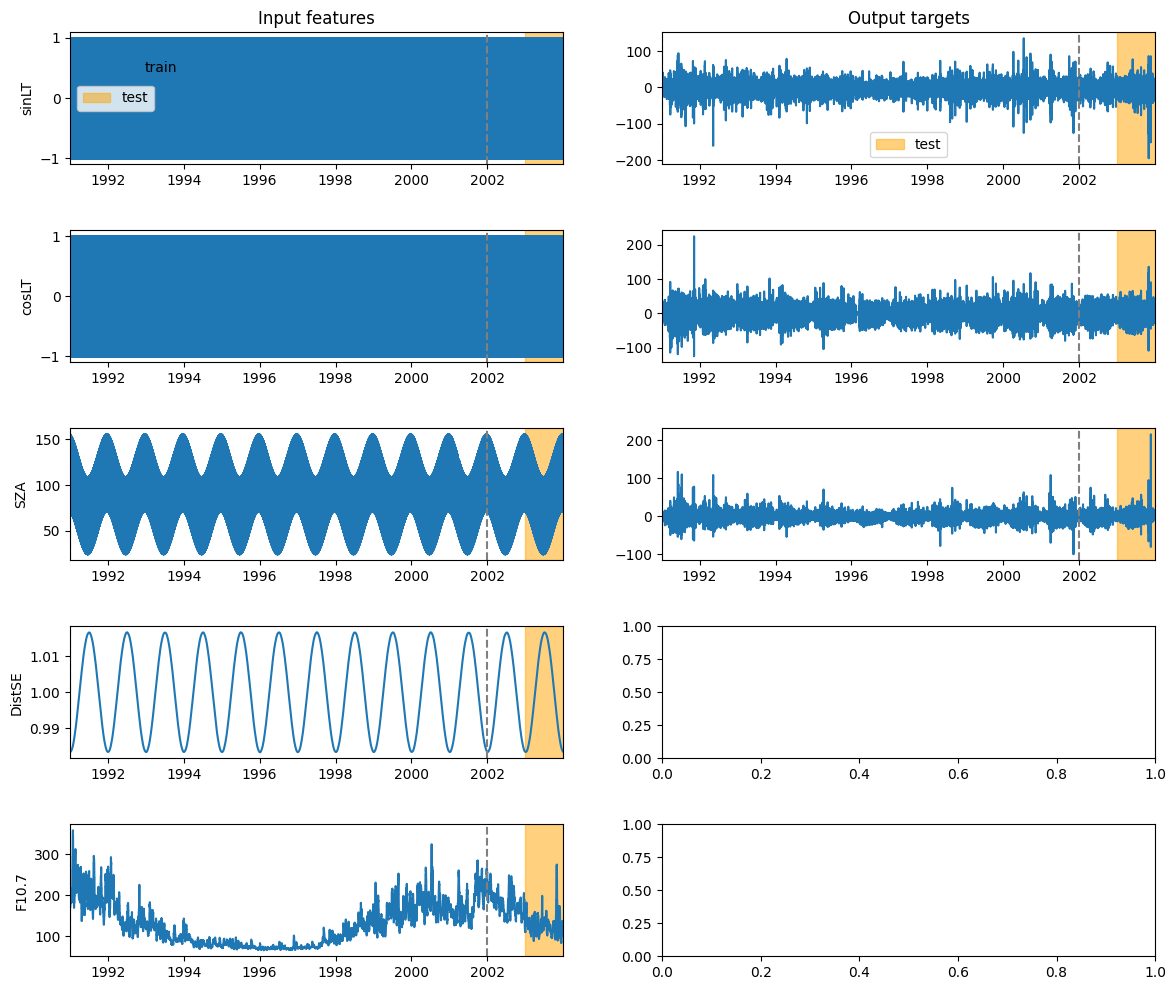

In [13]:
## Visualize data
fig, ax = plt.subplots(len(input_features), 2, figsize=(14,12))
plt.subplots_adjust(hspace=0.5)

i = 0
for col in input_features:
    if i < len(input_features):
        ax[i,0].plot(df[col])
        ax[i,0].axvline(x=t_train_begin, ls='--', color='grey')
        ax[i,0].axvline(x=t_train_end, ls='--', color='grey')
        ax[i,0].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='test')
        ax[i,0].set_xlim(t1, t2)
        ax[i,0].set_ylabel(col)
        i += 1 

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j,1].plot(df[col])
        ax[j,1].axvline(x=t_train_begin, ls='--', color='grey')
        ax[j,1].axvline(x=t_train_end, ls='--', color='grey')
        ax[j,1].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='test')
        ax[j,1].set_xlim(t1, t2)
        j += 1


ax[0,0].set_title('Input features')
ax[0,0].legend()
ax[0,0].text(0.15, 0.7, 'train', transform = ax[0,0].transAxes)

ax[0,1].set_title('Output targets')
ax[0,1].legend()

plt.show()

### Fix the new order of the columns

In [15]:
new_column_order = ['sinLT','cosLT','SZA','DistSE','F10.7','xD','yD','zD']
df = df[new_column_order]
df

,sinLT,cosLT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,,
1991-01-04 00:00:00,0.000000,1.000000,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,0.841471,0.540302,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,0.909297,-0.416147,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,0.141120,-0.989992,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,-0.756802,-0.653644,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...,...
2003-12-31 19:00:00,0.149877,0.988705,117.79,0.983311,102.1,-24.939013,18.532629,17.843970
2003-12-31 20:00:00,0.912945,0.408082,127.84,0.983310,102.1,-2.885442,15.901344,13.662172
2003-12-31 21:00:00,0.836656,-0.547729,137.61,0.983309,102.1,11.952557,16.504160,5.882234


### Limit the data range to only train + test data

In [16]:
df0 = df #save the original dataframe
df = df[t_train_begin:t_test_end]
df

,sinLT,cosLT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,,
1991-01-04 00:00:00,0.000000,1.000000,154.95,0.983283,170.2,-2.388678,15.367191,2.104001
1991-01-04 01:00:00,0.841471,0.540302,151.85,0.983284,170.2,-5.685187,13.831463,1.437988
1991-01-04 02:00:00,0.909297,-0.416147,144.78,0.983284,170.2,-6.717693,9.185361,1.888480
1991-01-04 03:00:00,0.141120,-0.989992,135.73,0.983284,170.2,-3.249444,4.324179,2.762322
1991-01-04 04:00:00,-0.756802,-0.653644,125.88,0.983284,170.2,2.946862,1.197555,2.502841
...,...,...,...,...,...,...,...,...
2003-12-31 19:00:00,0.149877,0.988705,117.79,0.983311,102.1,-24.939013,18.532629,17.843970
2003-12-31 20:00:00,0.912945,0.408082,127.84,0.983310,102.1,-2.885442,15.901344,13.662172
2003-12-31 21:00:00,0.836656,-0.547729,137.61,0.983309,102.1,11.952557,16.504160,5.882234


### Separate the data into train, validation, and test sets

In [17]:
df_train = df[t_train_begin:t_train_end]
df_val = df[t_val_begin:t_val_end]
df_test = df[t_test_begin:t_test_end]

## Scale the train data, obtain the scaling from the train data

In [18]:
## Scale the data frame
scaler = MinMaxScaler()

## Obtain scaler based on the "train" data
df_train_scaled = scaler.fit_transform(df_train)

## Convert from dataframe to 2D array
print('Train data: \n',df_train_scaled)
print(df_train_scaled.shape)

Train data: 
 [[0.50235679 1.         0.99565178 ... 0.53432308 0.40130096 0.47109679]
 [0.9250796  0.77014665 0.97200354 ... 0.52315435 0.39689126 0.46801321]
 [0.959153   0.29191271 0.9180703  ... 0.51965617 0.38355039 0.47009895]
 ...
 [0.49791023 0.         0.93119126 ... 0.54122316 0.35059269 0.47025095]
 [0.07724806 0.23356848 0.98123398 ... 0.47097893 0.39754653 0.49950489]
 [0.50235679 1.         0.99794031 ... 0.44276904 0.43377786 0.51850455]]
(95875, 8)


### Save the scaler for use later

In [19]:
from pickle import dump

# save the scaler
dump(scaler, open(scaler_file, 'wb'))

### Apply the scaling obtained from the "train" data to "validation" and "test" data

In [20]:
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

print('Validation data: \n',df_val_scaled)
print(df_val_scaled.shape)

print('Test data: \n',df_test_scaled)
print(df_test_scaled.shape)

Validation data: 
 [[0.2328031  0.92192545 0.35457098 ... 0.57491889 0.35742688 0.43396646]
 [0.71343262 0.95372248 0.36615861 ... 0.56695754 0.34772029 0.42891358]
 [1.         0.56836015 0.39588673 ... 0.55343321 0.34185229 0.42808245]
 ...
 [0.92266055 0.22612021 0.86314537 ... 0.53479385 0.38356525 0.46817905]
 [0.49791023 0.         0.9305047  ... 0.53509215 0.38174724 0.46808965]
 [0.07724806 0.23356848 0.9806237  ... 0.53977595 0.37565009 0.46675387]]
(8772, 8)
Test data: 
 [[0.2328031  0.92192545 0.35471592 ... 0.48024257 0.34099814 0.43657876]
 [0.71343262 0.95372248 0.36633407 ... 0.48930273 0.32175741 0.43750507]
 [1.         0.56836015 0.3960927  ... 0.51020802 0.31883368 0.45143057]
 ...
 [0.92266055 0.22612021 0.86337422 ... 0.58291189 0.40456567 0.48858965]
 [0.49791023 0.         0.93073355 ... 0.5761439  0.40297985 0.4588118 ]
 [0.07724806 0.23356848 0.98077627 ... 0.54001374 0.3828163  0.44793625]]
(8772, 8)


## Define X (independent variables: inputs) and y (dependent variables: outputs) 

In [21]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]

print('X train = \n',X_train)
print(X_train.shape)

## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]

print('y train = \n',y_train)
print(y_train.shape)

X train = 
 [[0.50235679 1.         0.99565178 0.00180366 0.3560477 ]
 [0.9250796  0.77014665 0.97200354 0.00181067 0.3560477 ]
 [0.959153   0.29191271 0.9180703  0.001818   0.3560477 ]
 ...
 [0.49791023 0.         0.93119126 0.00268357 0.58875639]
 [0.07724806 0.23356848 0.98123398 0.00266217 0.58875639]
 [0.50235679 1.         0.99794031 0.00264111 0.58534923]]
(95875, 5)
y train = 
 [[0.53432308 0.40130096 0.47109679]
 [0.52315435 0.39689126 0.46801321]
 [0.51965617 0.38355039 0.47009895]
 ...
 [0.54122316 0.35059269 0.47025095]
 [0.47097893 0.39754653 0.49950489]
 [0.44276904 0.43377786 0.51850455]]
(95875, 3)


### Separate the X and Y for the test and validation sets

In [22]:
X_val = df_val_scaled[:,0:len(input_features)]
X_test = df_test_scaled[:,0:len(input_features)]

y_val = df_val_scaled[:,len(input_features):len(input_features)+len(output_targets)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]

###  Transform X and y for Keras LSTM

In [23]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training """  
    X, y = list(), list()    
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        
        # if the index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequence for y
        seq_y = y_data[end_ix]        
        # Append the list with sequences
        X.append(seq_X)
        y.append(seq_y)    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

### Transform data to the sequences for LSTM network input

In [24]:
X_train_seq, y_train_seq = lstm_data_transform(X_train, y_train, num_steps=num_steps)
X_val_seq, y_val_seq = lstm_data_transform(X_val, y_val, num_steps=num_steps)
X_test_seq, y_test_seq = lstm_data_transform(X_test, y_test, num_steps=num_steps)

print ("The new shape of X train is", X_train_seq.shape)
print ("The new shape of y train is", y_train_seq.shape)

print ("The new shape of X val is", X_val_seq.shape)
print ("The new shape of y val is", y_val_seq.shape)

print ("The new shape of X test is", X_test_seq.shape)
print ("The new shape of y test is", y_test_seq.shape)

The new shape of X train is (95863, 12, 5)
The new shape of y train is (95863, 3)
The new shape of X val is (8760, 12, 5)
The new shape of y val is (8760, 3)
The new shape of X test is (8760, 12, 5)
The new shape of y test is (8760, 3)


## Train the model with the data

### Launch the Tensorboard to track the training

In [25]:
%tensorboard --logdir logs/fit
#%tensorboard --logdir=logs/fit/ --host localhost --port 6006

## Train the model

Epoch 1/100
374/375 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 1: val_loss improved from inf to 0.00093, saving model to Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5
375/375 [==============================] - 25s 58ms/step - loss: 0.0093 - val_loss: 9.2577e-04
Epoch 2/100
374/375 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 2: val_loss improved from 0.00093 to 0.00092, saving model to Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5
375/375 [==============================] - 19s 50ms/step - loss: 0.0034 - val_loss: 9.1968e-04
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss improved from 0.00092 to 0.00089, saving model to Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5
375/375 [==============================] - 19s 50ms/step - loss: 0.0023 - val_loss: 8.8698e-04
Epoch 4/100
375/375 [==============================] - ETA: 0s - loss: 

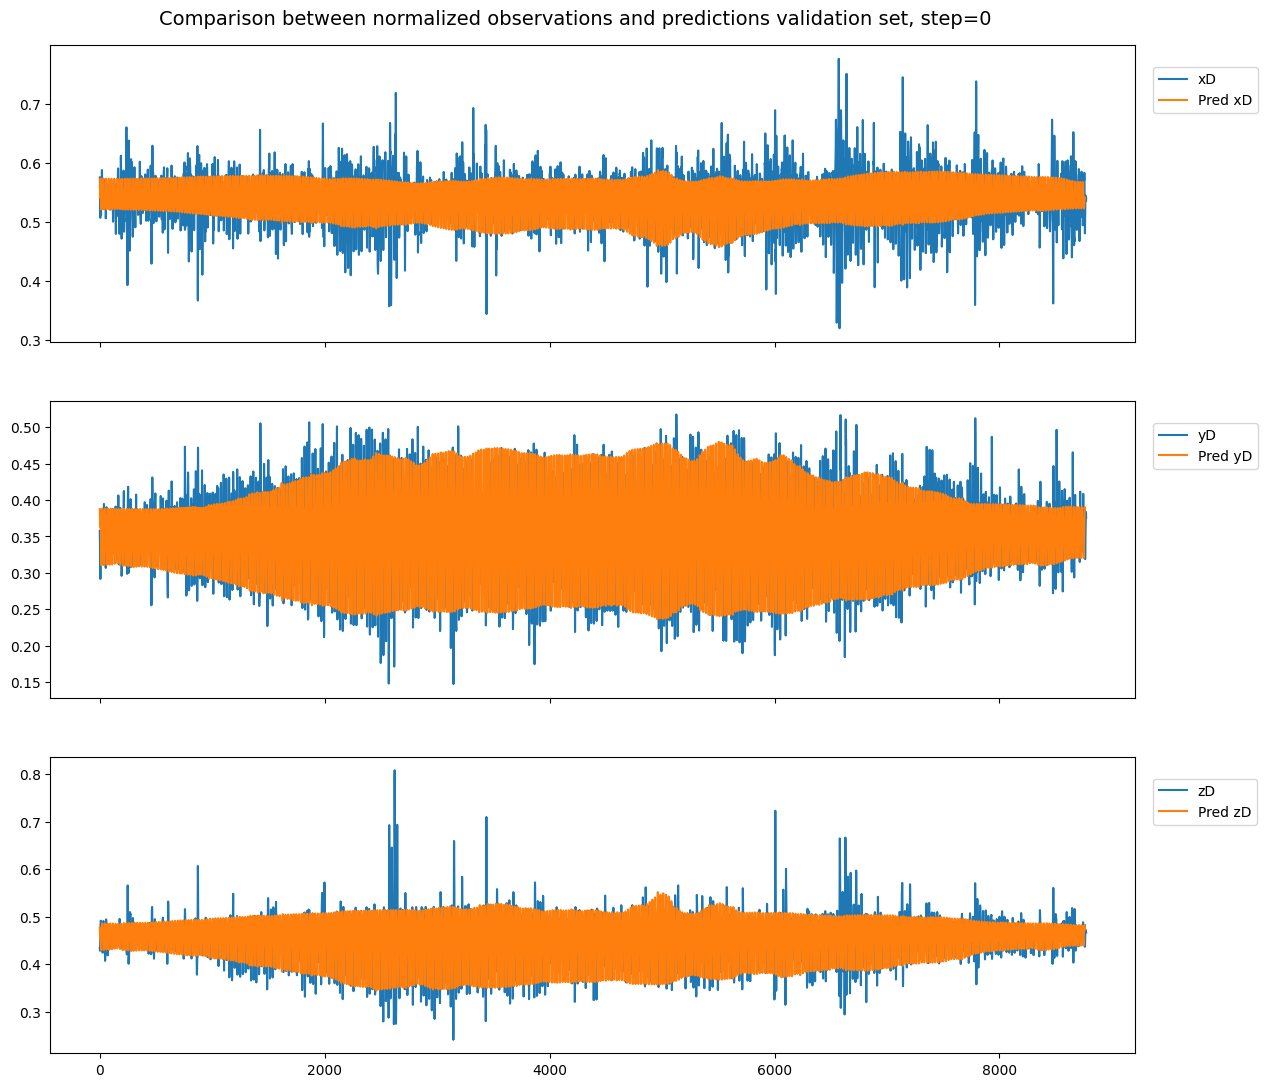

In [26]:
%%time

loss_score = []
mse_score = []

### Define log during training
log_dir = "logs/fit/" + str(folder_path) + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### checkpoint

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Call the model 
model=create_model()
    
### Fit the model
model.fit(X_train_seq, y_train_seq, epochs=100, 
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq), 
        callbacks=[tensorboard_callback, earlystopping_callback, checkpoint])

### Generate generalization metrics
print('Evaluation')
score = model.evaluate(X_val_seq, y_val_seq, verbose=0)
pred = model.predict(X_val_seq)
mse = mean_squared_error(y_val_seq[:,0], pred[:,0])
    
print(f'Test loss: ', score)
print(f'MSE of first target: ', mse)
    
loss_score.append(score)
mse_score.append(mse)
    
val_predict = model.predict(X_val_seq)

### Visualization for the validation data 
fig, ax = plt.subplots(len(output_targets), 1, figsize=(14,12))
plt.subplots_adjust(hspace=0.2)

target_labels = output_targets

for k in range(y_val.shape[1]):
    ax[k].plot(y_val[:,k], label=target_labels[k])
    ax[k].plot(val_predict[:,k], label='Pred {}'.format(target_labels[k]))
    ax[k].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))

for k in range(y_val.shape[1]-1):
    plt.setp(ax[k].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle("Comparison between normalized observations and predictions validation set, step=0", fontsize=14)

ax = plt.gca()
ax.figure.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0.2)
print('Fig saved to ', figname)

### Results on the test data

In [27]:
## Load the saved model 
filepath

'Saved_models/DailyQuietVariation_LSTM_Initial/Step0_weights.best.hdf5'

In [28]:
model = tf.keras.models.load_model(filepath)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 100)         42400     
                                                                 
 lstm_5 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_6 (LSTM)               (None, None, 50)          20200     
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 113,153
Trainable params: 113,153
Non-tr

In [29]:
test_predict = model.predict(X_test_seq)
print(test_predict.shape)

274/274 [==============================] - 2s 4ms/step
(8760, 3)


# Performance on the scaled test data

In [30]:
score_test = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test_seq.shape[1]):
    mse_test.append(mean_squared_error(y_test_seq[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

274/274 [==============================] - 2s 5ms/step - loss: 0.0013

Loss score =  0.0012912247329950333

MSE of all targets =  [0.0017908775315331079, 0.0009273483661268739, 0.0011554483268532072]


In [31]:
### Pearson correlation coefficients
Pcc_xyz_test = []
for i in range(y_test_seq.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test_seq[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)

### R2 score
r2_xyz_test = []
for i in range(y_test_seq.shape[1]):
    r2_xyz_test.append(round(r2_score(y_test_seq[:,i], test_predict[:,i]),3))
print('\nr2 of all targets = ', r2_xyz_test)


Pcc of all targets =  [0.586, 0.822, 0.677]

r2 of all targets =  [0.326, 0.675, 0.458]


## Visualize model results on the test set with metrics

Text(0.5, 0.98, 'Comparison between normalized observations and predictions')

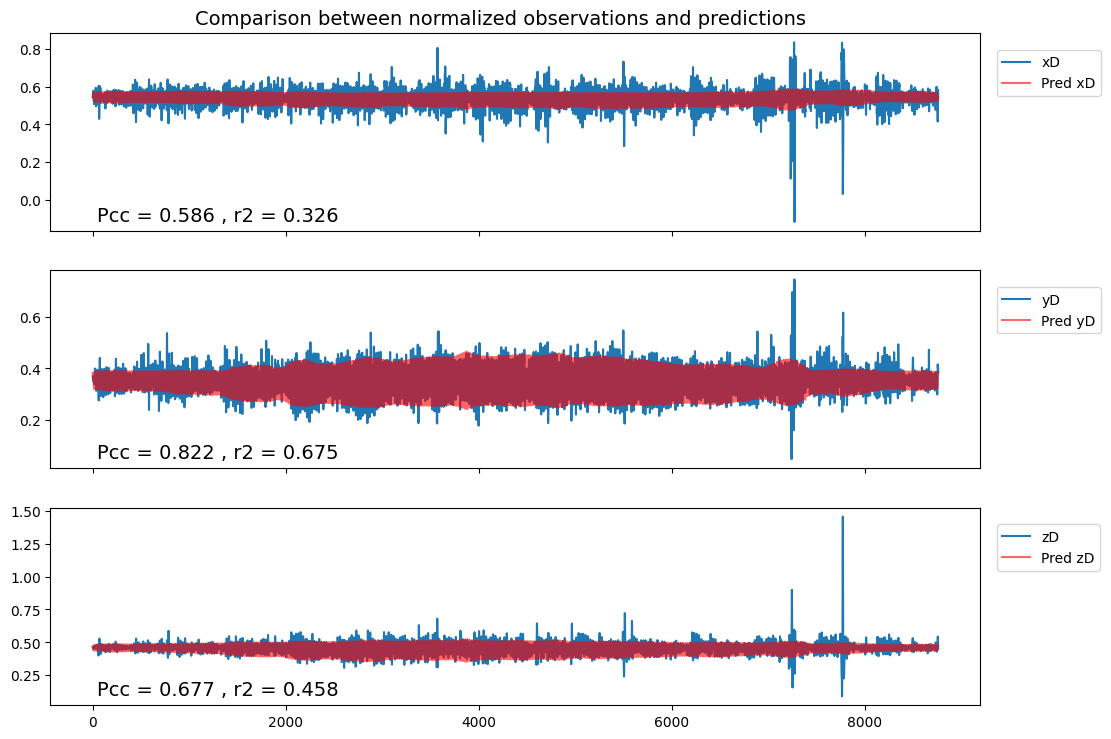

In [32]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

target_labels = output_targets

for i in range(y_test_seq.shape[1]):
    ax[i].plot(y_test_seq[:,i], label=target_labels[i])
    ax[i].plot(test_predict[:,i], label='Pred {}'.format(target_labels[i]), color='r', alpha=0.6)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i])) + str(' , r2 = {}'.format(r2_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test_seq.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle("Comparison between normalized observations and predictions", fontsize=14)

## Scale back the data

### Concatenate the scaled 'X' and the 'test predict'

In [33]:
predict_scaled = np.concatenate((X_test_seq[:,0,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(8760, 8)
[[0.2328031  0.92192545 0.35471592 ... 0.54528761 0.38254425 0.46815267]
 [0.71343262 0.95372248 0.36633407 ... 0.54586947 0.37349284 0.46156019]
 [1.         0.56836015 0.3960927  ... 0.54708529 0.3662295  0.45719665]
 ...
 [0.70938934 0.04441615 0.43106921 ... 0.53921908 0.38174406 0.47949082]
 [0.22906142 0.08044622 0.38880752 ... 0.5419274  0.38564819 0.47757071]
 [0.         0.5022031  0.36255798 ... 0.54413414 0.38527805 0.47324994]]


## Unscale the prediction

In [34]:
from pickle import load

# load the scaler
load_scaler = load(open(scaler_file, 'rb'))

In [35]:
predict = load_scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[-5.36572918e-01  8.43853959e-01  7.09310000e+01 ...  8.47557887e-01
   8.83495985e+00  1.46811002e+00]
 [ 4.20167037e-01  9.07446781e-01  7.24540000e+01 ...  1.01929698e+00
   5.68270648e+00  4.42187773e-02]
 [ 9.90607356e-01  1.36737218e-01  7.63550000e+01 ...  1.37815112e+00
   3.15317144e+00 -8.98248955e-01]
 ...
 [ 4.12118485e-01 -9.11130262e-01  8.09400000e+01 ... -9.43598891e-01
   8.55628411e+00  3.91700314e+00]
 [-5.44021111e-01 -8.39071529e-01  7.54000000e+01 ... -1.44225710e-01
   9.91594150e+00  3.50228542e+00]
 [-9.99990207e-01  4.42569799e-03  7.19590000e+01 ...  5.07105627e-01
   9.78703451e+00  2.56905466e+00]]
(8760, 8)


### Make a dataframe

In [36]:
df_predict = pd.DataFrame(predict)
df_predict.columns = new_column_order
df_predict

,sinLT,cosLT,SZA,DistSE,F10.7,xD,yD,zD
0,-0.536573,0.843854,70.931,0.983346,111.3,0.847558,8.834960,1.468110
1,0.420167,0.907447,72.454,0.983345,111.3,1.019297,5.682706,0.044219
2,0.990607,0.136737,76.355,0.983345,111.3,1.378151,3.153171,-0.898249
3,0.650288,-0.759688,82.271,0.983344,111.3,1.580677,1.538170,-1.426778
4,-0.287903,-0.957659,89.764,0.983344,111.3,2.919194,0.442222,-1.613423
...,...,...,...,...,...,...,...,...
8755,0.656987,0.753902,96.593,0.983323,102.1,-2.780532,2.490131,4.174042
8756,0.989358,-0.145500,88.147,0.983322,102.1,-1.734756,5.753792,4.009811
8757,0.412118,-0.911130,80.940,0.983321,102.1,-0.943599,8.556284,3.917003
8758,-0.544021,-0.839072,75.400,0.983320,102.1,-0.144226,9.915941,3.502285


In [37]:
df_predict['time'] = df_test.index[num_steps:]
df_predict = df_predict.set_index(['time'])
df_predict

,sinLT,cosLT,SZA,DistSE,F10.7,xD,yD,zD
time,,,,,,,,
2003-01-01 00:00:00,-0.536573,0.843854,70.931,0.983346,111.3,0.847558,8.834960,1.468110
2003-01-01 01:00:00,0.420167,0.907447,72.454,0.983345,111.3,1.019297,5.682706,0.044219
2003-01-01 02:00:00,0.990607,0.136737,76.355,0.983345,111.3,1.378151,3.153171,-0.898249
2003-01-01 03:00:00,0.650288,-0.759688,82.271,0.983344,111.3,1.580677,1.538170,-1.426778
2003-01-01 04:00:00,-0.287903,-0.957659,89.764,0.983344,111.3,2.919194,0.442222,-1.613423
...,...,...,...,...,...,...,...,...
2003-12-31 19:00:00,0.656987,0.753902,96.593,0.983323,102.1,-2.780532,2.490131,4.174042
2003-12-31 20:00:00,0.989358,-0.145500,88.147,0.983322,102.1,-1.734756,5.753792,4.009811
2003-12-31 21:00:00,0.412118,-0.911130,80.940,0.983321,102.1,-0.943599,8.556284,3.917003


In [38]:
outfile = data_path + "/prediction_DailyQuietVariation_" + df_predict.index[0].strftime("%Y") + ".csv"
df_out = df_predict[['xD','yD','zD']]
df_out.to_csv(outfile, sep=',', header=True)
print("Output saved as", outfile)
print(df_out)

Output saved as Saved_data/DailyQuietVariation_LSTM_Initial/prediction_DailyQuietVariation_2003.csv
                           xD        yD        zD
time                                             
2003-01-01 00:00:00  0.847558  8.834960  1.468110
2003-01-01 01:00:00  1.019297  5.682706  0.044219
2003-01-01 02:00:00  1.378151  3.153171 -0.898249
2003-01-01 03:00:00  1.580677  1.538170 -1.426778
2003-01-01 04:00:00  2.919194  0.442222 -1.613423
...                       ...       ...       ...
2003-12-31 19:00:00 -2.780532  2.490131  4.174042
2003-12-31 20:00:00 -1.734756  5.753792  4.009811
2003-12-31 21:00:00 -0.943599  8.556284  3.917003
2003-12-31 22:00:00 -0.144226  9.915941  3.502285
2003-12-31 23:00:00  0.507106  9.787035  2.569055

[8760 rows x 3 columns]


## Measure MSE on the unscaled data

In [40]:
# Actual data 
y_true = df0[df_out.index[0]:df_out.index[-1]]
y_true = np.array(y_true[['xD','yD','zD']])
# Predicted data 
y_predict = np.array(df_out[['xD','yD','zD']])
# Compute MSE 
mse_unscaled = []
for i in range(3):
    mse_unscaled.append(mean_squared_error(y_true[:,i], y_predict[:,i]))
print('\nMSE of all targets = ', mse_unscaled)


MSE of all targets =  [156.01502053160485, 112.47407934301513, 53.90216573436376]


## RMSE on the unscaled data, units: nanotesla (nT)

In [41]:
rmse_xyz = np.sqrt(mse_unscaled)
total_rmse = np.linalg.norm(np.sqrt(mse_unscaled))

print('RMSE of all targets = ', rmse_xyz) 
print('Total RMSE = ', total_rmse)

RMSE of all targets =  [12.49059728 10.60537974  7.34180943]
Total RMSE =  17.955257325056184


## Visualize rescaled prediction versus observation (final results)

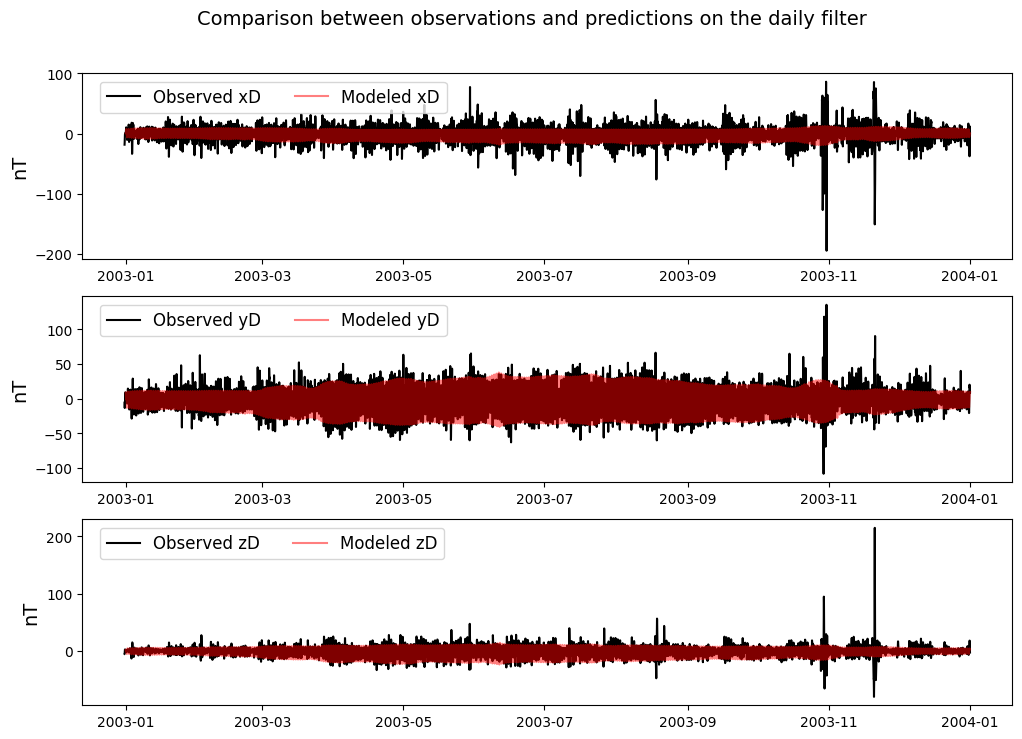

In [42]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j].plot(df0[t_test_begin:t_test_end][col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict[col], label='Modeled ' + col, color='r', alpha=0.5)
        ax[j].legend(loc='upper left',bbox_to_anchor=(.01, 1.0),ncols=2, fontsize=12)
        ax[j].set_ylabel('nT', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        j += 1
 
fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the daily filter", fontsize=14)

plt.show()

### Zoom in for the Halloween event

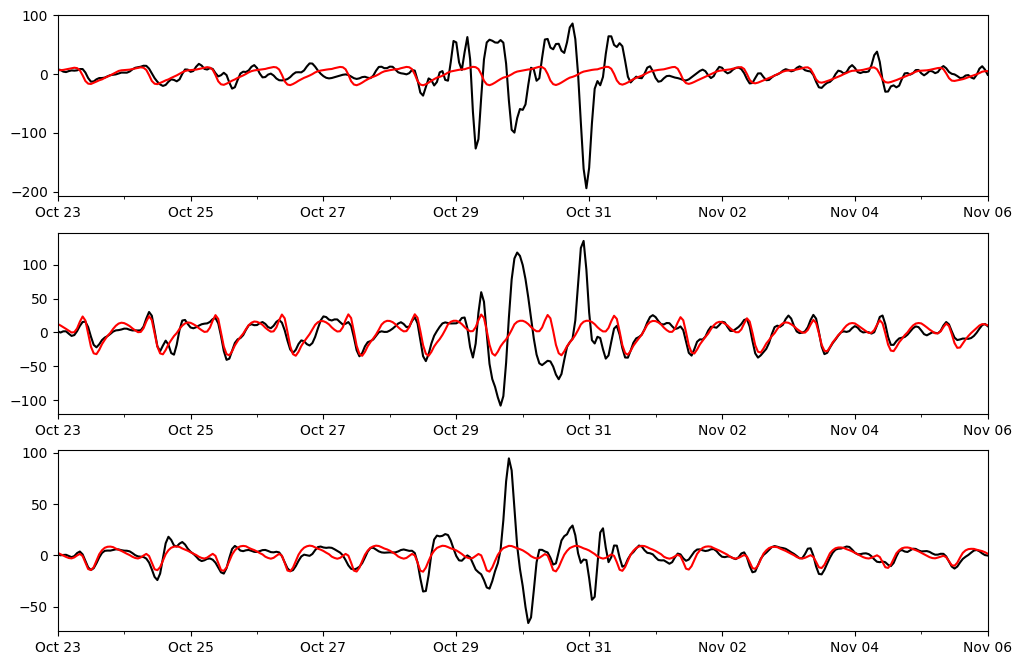

In [43]:
t_zoom_begin = datetime(2003,10,23)
t_zoom_end = datetime(2003,11,6)

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j].plot(df0[t_zoom_begin:t_zoom_end][col], label='Filter ' + col, color='k')
        ax[j].plot(df_predict[t_zoom_begin:t_zoom_end][col], label='NN ' + col, color='r')
        ax[j].xaxis.set_major_locator(mdates.DayLocator(interval=2))  
        ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
        ax[j].xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax[j].set_xlim(t_zoom_begin,t_zoom_end)
        j += 1